In [324]:
import random,math
from collections import defaultdict
from collections import Counter

class job():
    def __init__(self,t,num,m):
        self.state = str(m)
        self.num = str(num)
        self.time = t

# --- support functions starts ---
        
## read file method
def read_para_trace(para_file,arrival_file,service_file):  
    with open(para_file,'r') as para:
        para_list = []
        for i in para:
            para_list.append(i.strip())
        servers,setup,delayoff = para_list[:] 
#         print('servers,setup,delayoff:',servers,setup,delayoff)
    para.close()
    
    with open(arrival_file,'r') as arr:
        arr_list =[]
        for i in arr:
            arr_list.append(int(i.strip()))
#         print('arrival:',arr_list)
    arr.close()
    
    with open(service_file,'r') as service:
        ser_list = []
        for i in service:
            ser_list.append(int(i.strip()))
#         print('service:',ser_list)
    service.close()
    return servers,setup,delayoff,arr_list,ser_list

def read_para_random(para_file,arrival_file,service_file):  
    with open(para_file,'r') as para:
        para_list = []
        for i in para:
            para_list.append(i.strip())
        servers,setup,delayoff,time_end = para_list[:] 
#         print('servers,setup,delayoff,time_end:',servers,setup,delayoff,time_end)
    para.close()
    
    with open(arrival_file,'r') as arr:
        for i in arr:
            arr_list = (float(i.strip()))
#         print('arrival:',arr_list)
    arr.close()
    
    with open(service_file,'r') as service:
        for i in service:
            ser_list = (float(i.strip()))
#         print('service:',ser_list)
    service.close()
    return servers,setup,delayoff,time_end,arr_list,ser_list

## read file method ends

def nextTime(rateParameter):
    return -math.log(1.0 - random.random()) / rateParameter

def generate_exp(T_end, arrival, service, fix = 0, seed = 0):
    arrival_list = []
    service_list = []
    arr , ser = 0.0, 0.0 
    fix = int(fix)
    seed = int(seed)
    if fix == 1:
        random.seed(seed)
    arr += nextTime(arrival)
    while arr<= T_end:
        arrival_list.append(arr)
        ser = nextTime(service)+nextTime(service)+nextTime(service)
        service_list.append(ser)
        arr += nextTime(arrival)
    return arrival_list,service_list
    print(len(arrival_list) == len(service_list))

def check_server(server_state): # check number of each state of servers
        count = []
        for  i in server_state:
            count.append(server_state[i][0])
        return Counter(count)
        
def check_job(depatcher_queue): # check jobs two states
    count = []
    for i in depatcher_queue:
        count.append(i.state)
    return Counter(count)

def find_server_num(server_state,time): 
    for i in server_state:
        if server_state[i][1] == time:
            return i
        
def find_longest_setup(server_state):
    time = 0
    num = 0
    for i in server_state:
        if server_state[i][0] == '1':
            if server_state[i][1] > time:
                time = server_state[i][1]
                num = i
    return num

def find_longest_delayedoff(server_state,master_clock):
    num = 0
    time = 0
    real_time = 0
    for i in server_state:
        if server_state[i][0] == '3':
#             print(i,server_state[i][1],master_clock)
            if server_state[i][1] - master_clock > time:
                time = server_state[i][1] - master_clock
                num = i
                real_time = server_state[i][1]
#     print(num,real_time)
    return num,real_time

def find_delayedoff_server(server_state,time):
    for i in server_state:
        if server_state[i][1] == time:
            return i
        
def combine_list(a,c,mode,T_end = 0.0):
    arrival_complete = []
#     print(len(a) == len(c))
    for i in range(len(a)):
        if mode == 'random':
            if c[i]<T_end:
                arrival_complete.append((a[i],c[i]))
        else:
            arrival_complete.append((a[i],c[i]))
    arrival_complete.sort(key = lambda x: x[1],reverse = False)
    return arrival_complete
    

# === support functions ends ===
        
# --- simulation main function ---

def simulate(mode,arr_list,ser_list,servers,setup_time,delayoff_time,time_end = 0.0):
    server_state = defaultdict(list)  # { server num:['state',time] } 
    event = [] # sorted by time -includes setup, arrival and complete
    master_clock = 0.0
    # arrival = [1.0, 2.0, 3.2, 3.3] 
    # service = [.1, .2, .3, .4]
    time_end = float(time_end)
    if mode =='trace':
        arrival,service = arr_list,ser_list
    elif mode == 'random_fix':
        arrival,service = generate_exp(time_end,arr_list,ser_list,1)
    else:
        arrival,service = generate_exp(time_end,arr_list,ser_list)
    respose_time = 0 # response time
    delayedoff  = float(delayoff_time)  # delayedoff time to off state (Tc)
    depatcher_queue = []  # jobs in the queue
    check_state = 0  
    job_num = 1
    setup_time = float(setup_time) # the time needed setting up an off server to process a job
    complete_time = [0.0]*len(arrival) # ordered by arrival time
    mrt = 0.0
    arrival_complete = [] # final list
    
    m = int(servers) # num of servers
    for i in range(1, m+1): # initialize servers
        server_state[i].append('0')
        server_state[i].append(0)

    # arrival = [11, 11.2, 11.3, 13] 
    # service = [1, 1.4, 5, 1]
    # # initialize
    # server_state[1].append('3')
    # server_state[1].append(20) 
    # server_state[2].append('3')
    # server_state[2].append(17) 
    # server_state[3].append('0')
    # server_state[3].append(0) 
        
    # ll=server_state # test
    server_state # server num:[ state, time(default = 0)]
    for x in arrival:
        event.append((x,'arrival'))
                     
    # print('event:',event,'\n')

    while len(event)!=0:
        event.sort(key = lambda x: x[0],reverse = False) # sorted event list by time
        event_now = event.pop(0)
        time_passed = event_now[0] - master_clock
        master_clock = event_now[0]
    #     print('-----------------------  -----------------------')
    #     print('event:',event,'\n')

        if event_now[1] =='arrival':
        #     print('arrival')

            check_server_state = check_server(server_state)
    #         print(check_server_state)
        #     print(set(check_state)) 
            check_job_state = check_job(depatcher_queue)
    #         print(check_job_state)
            
            if '3' in set(check_server_state): # at least one delayedoff server
                depatcher_queue.append(job(event_now[0],job_num,'Delayed'))
                delayedoff_to_busy,time = find_longest_delayedoff(server_state,master_clock)
                server_state[delayedoff_to_busy][0] = '4'
                temp = master_clock + service[job_num-1]
                
    #             print(len(event))
                for i in range(len(event)):
    #                 print(i)
                    if event[i] == (time,'delayedoff'):
                        event.pop(i)
                        break
                complete_time[int(depatcher_queue.pop().num)-1] = temp
                server_state[delayedoff_to_busy][1] = temp
                event.append((temp,'completed'))
                
    #             print('server_state:\n',server_state,'\n\ndepatcher_queue:\n',
    #                   [(i.num,i.state) for i in depatcher_queue],'\n\nmaster_clock:',master_clock,'\n')
    #             print('event:',event,'\n')
                job_num += 1
                continue
            
            elif '0' in set(check_server_state): # random choose one off server to setup
                depatcher_queue.append(job(event_now[0],job_num,'MARKED'))
                job_num += 1
    #             print(server_state)
                off_servers = [] # off state
                for i in server_state:
                    if server_state[i][0] =='0':
                        off_servers.append(i)
                temp = off_servers[random.randint(0,len(off_servers)-1)]
                server_state[temp][0]= '1'
                server_state[temp][1] = master_clock+setup_time
                event.append((master_clock+setup_time,'setup')) # what time setup finished
                
    #             print('server_state:\n',server_state,'\n\ndepatcher_queue:\n',
                      
    #                   [(i.num,i.state) for i in depatcher_queue],'\n\nmaster_clock:',master_clock,'\n')
    #             print('event:',event,'\n')

                continue
                
            else: # all busy (need to be inplemented)
                depatcher_queue.append(job(event_now[0],job_num,'UNMARKED'))
    #             print('server_state:\n',server_state,'\n\ndepatcher_queue:\n',
    #                   [(i.num,i.state) for i in depatcher_queue],'\n\nmaster_clock:',master_clock,'\n')
    #             print('event:',event,'\n')
                job_num += 1
                continue

        
        if event_now[1] =='setup': # time for this server to do job
    #         print('setup server is :',find_server_num(server_state, master_clock))
            temp = find_server_num(server_state, master_clock)
            server_state[temp][0]= '2'
            num = int(depatcher_queue.pop(0).num)-1
            busy_time = master_clock+service[num]
            complete_time[num] = busy_time
            server_state[temp][1] = busy_time
            
            event.append((busy_time,'completed')) # what time job completed
    #         print('event(setup):',event,'\n','\n\ndepatcher_queue:\n',
    #               [(i.num,i.state) for i in depatcher_queue],
    #               'server_state:\n',server_state,'\n\nmaster_clock:',master_clock,'\n')
            continue
        
        if event_now[1] =='completed':
            temp = find_server_num(server_state, master_clock) # num of server which completed job
            
            check_job_state = check_job(depatcher_queue)
    #         print('completed a job,',check_job_state,'\n')
            if 'MARKED' in check_job_state:
    #             print('\nthere are still marked jobs in queue\n')
                server_state[temp][0]= '2'
                num = int(depatcher_queue.pop(0).num)-1
                busy_time = master_clock+service[num] # job in the front 
                complete_time[num] = busy_time
                server_state[temp][1] = busy_time           
                
                event.append((busy_time,'completed')) # what time job completed
                
                if 'UNMARKED' in check_job_state:
                    # still some unmarked remain --> unmarked changed to marked
                    for i in depatcher_queue:
                        if i.state =='UNMARKED':
                            i.state = 'MARKED'
                            break
                else:
                    # no unmarked remain --> marked -1 setup -1
                    server_to_off = int(find_longest_setup(server_state))
    #                 print('server_to_off:',server_to_off,'\n',server_state)
                    for i in range(len(event)):
    #                     print(event[i],server_state[server_to_off])
                        if event[i] == (server_state[server_to_off][1],'setup'):
        #                     event.pop((server_state[server_to_off][1],'setup'))
                            event.pop(i)
                            break
                    server_state[server_to_off][0]= '0'
                    server_state[server_to_off][1]= 0
                
    #             print('event(complete,marked):',event,'\n','\n\ndepatcher_queue:\n',
    #                   [(i.num,i.state) for i in depatcher_queue],'server_state:\n',server_state,
    #                   '\n\nmaster_clock:',master_clock,'\n')
                continue
            elif 'UNMARKED' in check_job_state:
    #             print('\nthere are unmarked jobs in queue\n')
                server_state[temp][0]= '2'
                num = int(depatcher_queue.pop(0).num)-1
                busy_time = master_clock+service[num]
                complete_time[num] = busy_time
                server_state[temp][1] = busy_time
                event.append((busy_time,'completed')) # what time job completed
    #             print('\nprocessing job {} server time is {}'.format(depatcher_queue [0].num,busy_time-master_clock))
    #             print('event(complete,unmarked):',event,'\n','\n\ndepatcher_queue:\n',
    #                   [(i.num,i.state) for i in depatcher_queue],'server_state:\n',server_state,
    #                   '\n\nmaster_clock:',master_clock,'\n')
                continue
            else:
    #             print('\nno jobs in queue\n')
                server_state[temp][0]= '3'
                delayedoff_time = master_clock+delayedoff
                server_state[temp][1] = delayedoff_time
                event.append((delayedoff_time,'delayedoff')) # delayedoff
    #             print('\n processing job {} server time is {}'.format(depatcher_queue[0].num,busy_time-master_clock))
    #             print('event(complete,else):',event,'\n','\n\ndepatcher_queue:\n',
    #                   [(i.num,i.state) for i in depatcher_queue],'server_state:\n',server_state,
    #                   '\n\nmaster_clock:',master_clock,'\n')
                continue
        if event_now[1] =='delayedoff':
            temp = find_delayedoff_server(server_state, master_clock)
    #         print(temp)
            server_state[temp][0]= '0'
            server_state[temp][1]= 0
            
    # mean response time
    if time_end != 0.0:
        arrival_complete = combine_list(arrival,complete_time,'random',float(time_end))
    else:
        arrival_complete = combine_list(arrival,complete_time,mode)
    for i in range(len(arrival_complete)):
#         print(complete_time[i],type(complete_time[i]),arrival[i],type(arrival[i]))
        mrt += arrival_complete[i][1]-arrival_complete[i][0]
    mrt = ('%.3f' %(mrt/len(arrival))) # mean response time

# #     print('\nfinished!\n','each jobs finished at:',complete_time,'mrt is :',mrt)
    print('\n{} jobs finished!\nmrt is :{}\n'.format(len(arrival_complete),mrt))
    return arrival_complete,mrt


# run a series of tests
def run_series():   
    a = [] # arrival list
    c = [] # complete list
    arrival_complete = []
    mean_time = 0.0
    
    # read num_tests file
    with open('num_tests.txt','r') as num:
        for i in num:
            tests = int(i.strip())
            # print('num of tests:',tests)
        num.close()

    # read other files according to num_tests.txt
    for i in range(1,tests+1):
        arrival_complete = [] # initialize
        mean_time = 0.0 # initialize
        
        mode_file = 'mode_{}.txt'.format(i) 
        para_file = 'para_{}.txt'.format(i)
        arrival_file = 'arrival_{}.txt'.format(i)
        service_file = 'service_{}.txt'.format(i)
    #     print(mode_file,para_file,arrival_file,service_file)
        
        with open(mode_file,'r') as mode:
            for j in mode:
                print('test {}:'.format(i))
                j = j.strip()
                if j=='trace':
                    servers,setup_time,delayoff_time,arr_list,ser_list = read_para_trace(para_file,arrival_file,service_file)
                    print('mode,servers,setup_time,delayoff_time,arr_list,ser_list:\n',
                          j,servers,setup_time,delayoff_time,arr_list,ser_list)
                    # do trace simulation
                    a_c = simulate(j,arr_list,ser_list,servers,setup_time,delayoff_time)
#                     arrival_complete = combine_list(a,c,j)
                elif j=='random':
                    servers,setup_time,delayoff_time,time_end,arr_list,ser_list = read_para_random(para_file,arrival_file,service_file)
                    print('mode,servers,setup_time,delayoff_time,time_end,arr_list,ser_list:\n',
                          j,servers,setup_time,delayoff_time,time_end,arr_list,ser_list)
                    # do random simulation
                    a_c = simulate(j,arr_list,ser_list,servers,setup_time,delayoff_time,time_end)
#                     arrival_complete = combine_list(a,c,j,float(time_end))
                else:
                    servers,setup_time,delayoff_time,time_end,arr_list,ser_list = read_para_random(para_file,arrival_file,service_file)
                    print('mode,servers,setup_time,delayoff_time,time_end,arr_list,ser_list:\n',
                          j,servers,setup_time,delayoff_time,time_end,arr_list,ser_list)
                    # do random simulation
                    a_c = simulate(j,arr_list,ser_list,servers,setup_time,delayoff_time,time_end)
#                     arrival_complete = combine_list(a,c,j,float(time_end))
        mode.close()
                   
        mrt_file = 'mrt_{}.txt'.format(i)
        departure_file ='departure_{}.txt'.format(i)

        mean_time = ('{0:.3f}'.format(float(a_c[1]))) # mean response time        
        
        with open(mrt_file,'w') as mrt:
            mrt.write('{}\n'.format(mean_time))
        mrt.close()
        
        with open(departure_file,'w') as dep:
            for i in range(len(a_c[0])):
                temp1 = ('{0:.3f}'.format(float(a_c[0][i][0])))
                temp2 = ('{0:.3f}'.format(float(a_c[0][i][1])))
                dep.write('{}\t{}\n'.format(temp1,temp2))
        dep.close()

In [325]:
run_series()

test 1:
mode,servers,setup_time,delayoff_time,arr_list,ser_list:
 trace 3 50 100 [10, 20, 32, 33] [1, 2, 3, 4]

4 jobs finished!
mrt is :41.250

test 2:
mode,servers,setup_time,delayoff_time,time_end,arr_list,ser_list:
 random 3 50 100 1000 0.35 1.0

345 jobs finished!
mrt is :4.611

test 3:
mode,servers,setup_time,delayoff_time,time_end,arr_list,ser_list:
 random_fix 3 50 100 1000 0.35 1.0

342 jobs finished!
mrt is :5.908

test 4:
mode,servers,setup_time,delayoff_time,time_end,arr_list,ser_list:
 random_fix 4 30 50 5000 0.7 1.0

3525 jobs finished!
mrt is :3.572

test 5:
mode,servers,setup_time,delayoff_time,time_end,arr_list,ser_list:
 random_fix 5 5 10 1000 0.5 1.0

510 jobs finished!
mrt is :3.922



In [314]:
simulate('random_fix',0.35,1,5,5,0.1,100)



37 jobs finished!
mrt is :6.178



([(5.31602031732921, 12.580004928056379),
  (7.361605316663926, 14.773651993798376),
  (9.211329515387648, 16.545350137177063),
  (10.157214921039806, 16.872772968246686),
  (19.915320911285267, 26.53481111463993),
  (18.089808550628085, 27.84151606174097),
  (17.029015485363168, 30.077375136240455),
  (27.754591813021236, 32.522036216576836),
  (26.892390103029264, 33.89387752016058),
  (31.388624785005998, 35.876068715550026),
  (31.391891850235623, 36.875806842326725),
  (32.515735831882246, 38.97015807567017),
  (33.86419138414459, 39.696058449854995),
  (33.53426059528607, 40.18737605462384),
  (33.294642561652694, 42.03599429971047),
  (38.67711075082986, 43.99135180993523),
  (41.207976194899594, 44.01778468515373),
  (43.65711643059906, 44.75096772296489),
  (46.36781545662845, 53.17824288655225),
  (50.416907469906725, 59.68893634723434),
  (56.94399654391793, 63.52821450493707),
  (60.43468529209289, 67.41371241551136),
  (66.87515990939391, 72.16264116103065),
  (73.09078713

In [294]:
from collections import defaultdict
sample = defaultdict(list)
mrt = 0.0
temp = 0.0
a_c = []
for i in range(10):
    a_c = simulate('random',0.35,1,5,5,20,20000)
    sample[i].append(a_c[0])
# print(sample)


7006 jobs finished!
mrt is :3.563


7057 jobs finished!
mrt is :3.533


6861 jobs finished!
mrt is :3.516


6994 jobs finished!
mrt is :3.581


6954 jobs finished!
mrt is :3.560


7040 jobs finished!
mrt is :3.558


7071 jobs finished!
mrt is :3.581


7058 jobs finished!
mrt is :3.537


6933 jobs finished!
mrt is :3.586


6969 jobs finished!
mrt is :3.541



In [233]:
[len(sample[jj][0]) for jj in sample]

[7047, 6873, 6969, 7081, 6956, 7004, 6904, 6978, 7124, 7031]

In [295]:
length = min([len(sample[i][0]) for i in sample])

def sumup(x,L):
    mean = 0.0
    for i in range(int(x)):
        mean += L[i][1] - L[i][0]
#         print(mean)
    return mean/x

for i in sample:
#     print(len(sample[i][0][101:length+1]),'------------\n',sample[i][0][101:length+1])
    print(sumup(len(sample[i][0][101:length+1]),sample[i][0][101:length+1]))
    


3.5659221195190454
3.5404910115171333
3.517620800474077
3.586713535421931
3.556310312317443
3.5629866548341043
3.5756041785043338
3.529322491845899
3.5794976080108256
3.5413540282355234


In [296]:
[6.103755337833227-3.5659221195190454,
6.036903920786047-3.5404910115171333,
6.01941523556987-3.517620800474077,
6.059636558900138-3.586713535421931,
6.1308281500007-3.556310312317443,
6.062622154824946-3.5629866548341043,
6.061100456436297-3.5756041785043338,
6.0369751961009035-3.529322491845899,
5.979168710456368-3.5794976080108256,
6.036846181790869-3.5413540282355234]

[2.5378332183141814,
 2.496412909268914,
 2.5017944350957926,
 2.472923023478207,
 2.574517837683257,
 2.4996354999908417,
 2.4854962779319636,
 2.5076527042550043,
 2.3996711024455424,
 2.495492153555346]

In [298]:
import math
sam =[-2.5378332183141814,
 -2.496412909268914,
 -2.5017944350957926,
 -2.472923023478207,
 -2.574517837683257,
 -2.4996354999908417,
 -2.4854962779319636,
 -2.5076527042550043,
 -2.3996711024455424,
 -2.495492153555346]

me = sum(sam)/len(sam)  # mean
std = [(i-me)**2 for i in sam]
stdd = sum(std)/len(std)
stdd #std
me + 2.262*stdd/math.sqrt(10)

-2.495854852200156

In [246]:
length = min([len(sample[i][0]) for i in sample])

L = []
# for i in sample:
#     print('------')
#     for j in range(1,length):
#         mrtt = 0.0
#         for m in range(j):
#             mrtt += sample[i][0]
def comp(x,arrival_complete):
    mean = 0.0
    for i in range(int(x)+1):
        mean += arrival_complete[i][1]-arrival_complete[i][0]
    return mean/(x+1)
LL = np.zeros(length)
for j in sample:
    x = [ i for i in range(length)]
    p = [comp(i,sample[j][0][:length]) for i in x]
    p = np.array(p)
    print(p)
    LL += p
LL

[6.544229   5.77752936 4.88031644 ... 6.10098191 6.101221   6.10088462]
[7.60579933 7.87900232 6.11565587 ... 6.03247224 6.03191408 6.03196307]
[6.65680488 4.72404531 5.04173967 ... 6.02065763 6.02087041 6.02048221]
[9.96830473 6.72928318 6.27745666 ... 6.06408361 6.06521499 6.06458528]
[6.61027169 8.37511774 7.73735794 ... 6.12254502 6.12212499 6.12280383]
[6.43012362 5.84433876 4.29726139 ... 6.06718627 6.06701379 6.06663759]
[6.62570668 6.24967653 7.93568741 ... 6.06728307 6.06762247 6.06733078]
[8.12215853 7.86433986 7.53344256 ... 6.03931341 6.03925865 6.0390443 ]
[7.30271345 7.1125393  8.0942897  ... 5.98558126 5.98502073 5.9844617 ]
[6.56472807 7.7229114  7.25172097 ... 6.0332812  6.03291254 6.03293049]


array([72.43083999, 68.27878375, 65.16492862, ..., 60.53338562,
       60.53317365, 60.53112388])

In [163]:
LL = LL/10

In [278]:
t_m = sum(LL[101:])/len(LL[101:])
std = 0.0
for i in LL[101:]:
    std+=(i-t_m)**2
std = std/(len(LL[101:])-1)
print(std)

import math
from scipy.stats import t

tt = t._ppf((1+0.95)/2., 10-1)
t_m + tt*std/math.sqrt(10)

0.011506666085639435


60.6324217320903

(5.5, 7.0)

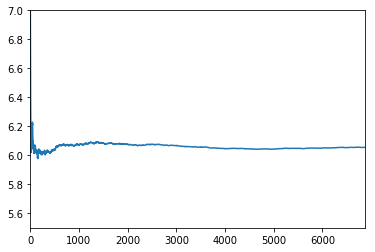

In [177]:
xx = [x for x in range(len(LL))]
# print(xx)
plt.plot(xx,LL)
plt.xlim(0, len(LL))# set axis limits
plt.ylim(5.50, 7.0)

(5.5, 7.0)

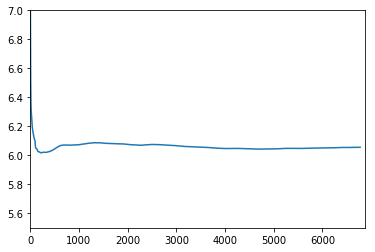

In [215]:
def smooth(l,w):
    l_new = [0]*(len(l)-w+1)
#     print(len(l_new),len(l))
    temp = 0.0
    for i in range(w):
        l_new[i] = sum(l[(i-(i)):(2*i+1)])/(2*i+1)
#         print(l_new[i])
    for i in range(w,len(l)-w):
#         print(i)
        l_new[i] = sum(l[(i-w):(i+w+1)])/(2*w+1)
    l_new[len(l)-w] = sum(l[(i-w):])/(2*w+1)
        
    return l_new


bb = smooth(LL,100)

xx = [x for x in range(len(bb))]
# print(xx)
plt.plot(xx,bb)
plt.xlim(0, len(LL))# set axis limits
plt.ylim(5.50, 7.0)

In [112]:
# draw dot graph

arrival_complete = a_c[0]
l = len(arrival_complete)
print(l)

import numpy as np
from matplotlib import pyplot as plt

def comp(x):
    mean = 0.0
    for i in range(int(x)):
        mean += arrival_complete[i][1]-arrival_complete[i][0]
    return mean/(x+1)

x = [ i for i in range(1,l)]
p = [comp(i-1) for i in x]


7024


(5, 10.0)

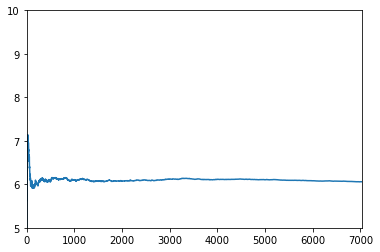

In [110]:
plt.plot(x,p)
plt.xlim(0, l)# set axis limits
plt.ylim(5, 10.0,1)


In [317]:
import numpy as np
from matplotlib import pyplot as plt

def my_dist(x):
    return 1- np.exp(-1/10*x)

def my_dist1(x):
    return -np.log(1-random.random())/x

# x = np.arange(0, 10, 0.01)
# p = my_dist1(x)
# plt.plot(x, p)
# plt.show()

import numpy as np
import random
from matplotlib import pyplot as plt

x = []
y = []
for i in range(50000):
    x.append(10)
for i in x:
    y.append(my_dist1(i))
    
# plt.plot(x, y,'o')
# plt.xlim(0, 10)# set axis limits
# plt.ylim(0, 100,1)

# print(x,y)



Counter({1: 4725, 2: 4326, 3: 3889, 4: 3551, 5: 3246, 6: 2947, 7: 2593, 8: 2364, 9: 2082, 10: 1839, 11: 1752, 12: 1603, 13: 1426, 14: 1306, 15: 1142, 16: 1002, 17: 925, 18: 838, 19: 796, 20: 703, 21: 645, 22: 580, 23: 568, 24: 462, 25: 437, 26: 384, 27: 366, 28: 353, 29: 300, 30: 281, 32: 242, 31: 233, 33: 195, 34: 182, 36: 162, 35: 156, 37: 124, 38: 116, 39: 107, 41: 104, 40: 97, 42: 84, 43: 83, 45: 63, 44: 61, 46: 59, 47: 48, 49: 42, 52: 40, 51: 38, 48: 36, 50: 36, 55: 27, 53: 21, 54: 19, 58: 16, 62: 16, 56: 16, 59: 12, 64: 12, 63: 12, 61: 11, 57: 11, 66: 8, 68: 7, 72: 7, 60: 6, 75: 6, 71: 6, 67: 6, 69: 5, 65: 5, 73: 4, 77: 3, 74: 3, 83: 3, 82: 2, 78: 2, 79: 2, 70: 2, 80: 1, 115: 1, 86: 1, 89: 1, 76: 1, 93: 1, 112: 1, 87: 1, 81: 1, 94: 1, 90: 1})
[2.9, 0.5, 0.2, 3.0, 1.8, 0.1, 0.7, 0.3, 1.6, 0.9, 4.6, 0.8, 1.7, 0.6, 0.4, 2.4, 1.3, 2.1, 2.8, 1.5, 2.3, 1.2, 1.9, 5.3, 2.0, 3.2, 3.7, 1.0, 1.4, 2.7, 4.1, 1.1, 3.5, 3.3, 2.5, 2.2, 4.5, 2.6, 4.2, 3.1, 3.8, 4.9, 5.1, 5.4, 3.4, 5.9, 6.1, 4.0, 

(0, 1000)

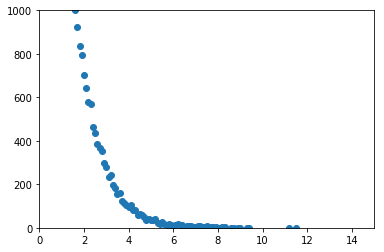

In [319]:
import numpy as NP
A = NP.random.randint(0, 1, 100)

# bins = NP.array([0., 1., 2., 3., 4., 5.])

bins = NP.arange(0., 5.,0.01)

# d is an index array holding the bin id for each point in A
d = NP.digitize(y, bins) 
from collections import Counter
d = Counter(d)
print(d)
x = []
z = []
for i in d:
    x.append(i/10)
    z.append(d[i])
print(x,z)
plt.plot(x, z,'o')
plt.xlim(0, 15,1)# set axis limits
plt.ylim(0, 1000,1)
    